In [74]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from matplotlib.ticker import LogLocator
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data_StbleTgt_WRMSE import get_config as get_stbltgt_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt import get_config as get_stbltgt_config



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [76]:
config = get_config()
sble_tgt_config = get_stbltgt_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

0.0
Using CPU



In [77]:
def get_drift_files(config, ts_type_str):
    ts_type = f"{ts_type_str}"
    if "BiPot" in ts_type_str:
        include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                    ".", "")
    elif "QuadSin" in ts_type_str:
        include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file:
                    driftevalexp_files.append(root_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_dir+file)
                elif "OOSDriftTrack" in file and "local" in file:
                    driftoostrack_local_files.append(root_dir+file)
    #assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    #assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert len(driftevalexp_files)>0, "No eval exp files found"
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [78]:
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = "ST_fBiPot"
    else:
        ts_type_str = "fBiPot"
elif "QuadSinHF" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = "ST_fQuadSinHF"
    else:
        ts_type_str = "fQuadSinHF"
print(ts_type_str)
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, ts_type_str=ts_type_str)

fBiPot


In [79]:
if "BiPot" in sble_tgt_config.data_path:
    if "_ST_" in sble_tgt_config.scoreNet_trained_path:
        ts_type_str = "ST_fBiPot"
    else:
        ts_type_str = "fBiPot"
elif "QuadSinHF" in sble_tgt_config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = "ST_fQuadSinHF"
    else:
        ts_type_str = "fQuadSinHF"
print(ts_type_str)
sble_tgt_driftevalexp_files, sble_tgt_driftoostrack_true_files, sble_tgt_driftoostrack_local_files, sble_tgt_Nepochs_track, sble_tgt_Nepochs_drifteval = get_drift_files(config=sble_tgt_config, ts_type_str=ts_type_str)

ST_fBiPot


In [80]:
sble_tgt_driftevalexp_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fBiPot_DriftEvalExp_2Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fBiPot_DriftEvalExp_4Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fBiPot_DriftEvalExp_6Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fBiPot_DriftEvalExp_8Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fBiPot_DriftEvalExp_10Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LFac_muhats.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fBiPot_DriftEvalExp_12Nep_00t0_3906e-03dT_025a_-05b_00c_10ResLay_2LF

In [81]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 4)})
    except FileNotFoundError as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys()))
eval_exp_rmses

{1: 3.3066,
 2: 0.8328,
 4: 0.5499,
 6: 0.5422,
 8: 0.5555,
 10: 0.5496,
 12: 0.5761,
 14: 0.5041,
 16: 0.4928,
 18: 0.4764,
 20: 0.4352,
 22: 0.3543,
 24: 0.2491,
 26: 0.4348,
 28: 0.2737,
 30: 0.3295,
 32: 0.4358,
 34: 0.2702,
 36: 0.3146,
 38: 0.4534,
 40: 0.2088,
 42: 0.2278,
 44: 0.1845,
 46: 0.2938,
 48: 0.3905,
 50: 0.1616,
 52: 0.2086,
 54: 0.1423,
 56: 0.2308,
 58: 0.1607,
 60: 0.2983,
 62: 0.197,
 64: 0.1986,
 66: 0.2825,
 68: 0.2872,
 70: 0.1459,
 72: 0.1434,
 74: 0.1597,
 76: 0.436,
 78: 0.2648,
 80: 0.145,
 82: 0.1686,
 84: 0.2293,
 86: 0.3392,
 88: 0.2885,
 90: 0.4652,
 92: 0.1847,
 94: 0.5174,
 96: 0.2335,
 98: 0.4583,
 100: 0.2596,
 102: 0.1131,
 104: 0.1245,
 106: 0.1493,
 108: 0.1519,
 110: 0.2576,
 112: 0.307,
 114: 0.1835,
 116: 0.3556,
 118: 0.2171,
 120: 0.5042,
 122: 0.2615,
 124: 0.2074,
 126: 0.3741,
 128: 0.2066,
 130: 0.2899,
 132: 0.1678,
 134: 0.1894,
 136: 0.2749,
 138: 0.1419,
 140: 0.3094,
 142: 0.6022,
 144: 0.109,
 146: 0.3725,
 148: 0.1978,
 150: 0.34

In [82]:
sble_tgt_eval_exp_rmses = {}
for f in zip(*[sble_tgt_Nepochs_drifteval, sble_tgt_driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*sble_tgt_config.quartic_coeff * np.power(Xs, 3) + 2.*sble_tgt_config.quad_coeff * Xs + sble_tgt_config.const).numpy()
        elif "QuadSin" in sble_tgt_config.data_path:
            true_drifts = (-2. * sble_tgt_config.quad_coeff * Xs + sble_tgt_config.sin_coeff * sble_tgt_config.sin_space_scale * np.sin(
        sble_tgt_config.sin_space_scale * Xs)).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        sble_tgt_eval_exp_rmses.update({Nepoch: round(rmse, 4)})
    except pickle.UnpicklingError as e:
        continue
    except FileNotFoundError as e:
        continue
sble_tgt_Nepochs_drifteval = np.array(list(sble_tgt_eval_exp_rmses.keys()))
sble_tgt_eval_exp_rmses

{2: 6.545,
 4: 0.7543,
 6: 0.6132,
 8: 0.6208,
 10: 0.6187,
 12: 0.6156,
 14: 0.62,
 16: 0.604,
 18: 0.6302,
 20: 0.613,
 22: 0.6086,
 24: 0.6084,
 26: 0.6008,
 28: 0.6112,
 30: 0.5978,
 32: 0.59,
 34: 0.5737,
 36: 0.5466,
 38: 0.5157,
 40: 0.4982,
 42: 0.4943,
 44: 0.4877,
 46: 0.476,
 48: 0.4756,
 50: 0.4843,
 52: 0.4777,
 54: 0.4686,
 56: 0.4878,
 58: 0.4861,
 62: 0.511,
 64: 0.4647,
 66: 0.4827,
 68: 0.4796,
 70: 0.4662,
 72: 0.472,
 74: 0.4972,
 76: 0.4561,
 78: 0.4332,
 80: 0.3196,
 82: 0.253,
 84: 0.2423,
 86: 0.2367,
 88: 0.2229,
 90: 0.2443,
 92: 0.2492,
 94: 0.2116,
 96: 0.2216,
 98: 0.1894,
 102: 0.1813,
 104: 0.1676,
 106: 0.2494,
 108: 0.1909,
 110: 0.1817,
 112: 0.2667,
 114: 0.1557,
 116: 0.2894,
 118: 0.1789,
 120: 0.1681,
 122: 0.2013,
 124: 0.1684,
 126: 0.1639,
 128: 0.2363,
 130: 0.1781,
 132: 0.1475,
 134: 0.2118,
 136: 0.1577,
 138: 0.1845,
 140: 0.1437,
 142: 0.312,
 144: 0.1769,
 146: 0.152,
 148: 0.256,
 152: 0.1261,
 154: 0.1706,
 156: 0.1929,
 158: 0.1407,
 1

In [86]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except FileNotFoundError as e:
        print(e)
        continue
drift_track_rmses

{10: 0.02334365479542606}

In [87]:
sble_tgt_drift_track_rmses = {}
for f in zip(*[sble_tgt_Nepochs_track, sble_tgt_driftoostrack_true_files, sble_tgt_driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true)/np.sqrt(sble_tgt_config.deltaT)
        all_local_states= np.load(local)/np.sqrt(sble_tgt_config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        sble_tgt_drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except FileNotFoundError as e:
        print(e)
        continue
sble_tgt_Nepochs_track = np.array(list(sble_tgt_drift_track_rmses.keys()))
sble_tgt_drift_track_rmses

{2: 0.4061680762829273,
 4: 0.03237084400681871,
 6: 0.01972271148549396,
 10: 0.020379299822750094,
 12: 0.020589862577828508,
 14: 0.02122487973829055,
 16: 0.019129758411409677,
 18: 0.0211813111965922,
 20: 0.021082548393749685,
 22: 0.0201236402627372,
 24: 0.020188547794747297,
 26: 0.019827838714149476,
 28: 0.02122085554481413,
 30: 0.020533624329243067,
 32: 0.02029562164688516,
 34: 0.020241664675592342,
 36: 0.019830915477511316,
 38: 0.02102060599730205,
 40: 0.020861457402225777,
 42: 0.01944475579216497,
 44: 0.01918246779193713,
 46: 0.019864606093144787,
 50: 0.019999435623479497,
 52: 0.018433746482466186,
 54: 0.019354203326773883,
 56: 0.018801002722437947,
 62: 0.018401462789013993,
 64: 0.01887778168339683,
 66: 0.018021196816970193,
 70: 0.017885466617013894,
 72: 0.018037304599906972,
 74: 0.01775199497485363,
 76: 0.015032007659930065,
 80: 0.012039024585118779,
 82: 0.010620845365992112,
 84: 0.009979647266808167,
 86: 0.010521826424649456,
 90: 0.0116689624850

In [84]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
        Nepochs = np.arange(losses.shape[0])
with open(sble_tgt_config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        stbl_tgt_losses = np.array(pickle.load(f)).astype(float)
        stbl_tgt_Nepochs = np.arange(stbl_tgt_losses.shape[0])

common_epochs = np.intersect1d(Nepochs_drifteval, np.intersect1d(sble_tgt_Nepochs_drifteval, np.intersect1d(stbl_tgt_Nepochs, Nepochs)))
#common_epochs = common_epochs[np.array([(10<=c<=960) for c in common_epochs])]
start_idx = 2
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs)[0,0] for c in common_epochs]
stbl_tgt_losses_idx = [np.argwhere(c == stbl_tgt_Nepochs)[0,0] for c in common_epochs]
domain_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
stbl_tgt_domain_idx = [np.argwhere(c == sble_tgt_Nepochs_drifteval)[0,0] for c in common_epochs]

red_losses = losses[losses_idx]
red_stbl_tgt_losses = stbl_tgt_losses[stbl_tgt_losses_idx]
red_domain_rmse = np.array(list(eval_exp_rmses.values()))[domain_idx]
red_sble_tgt_domain_rmse = np.array(list(sble_tgt_eval_exp_rmses.values()))[stbl_tgt_domain_idx]

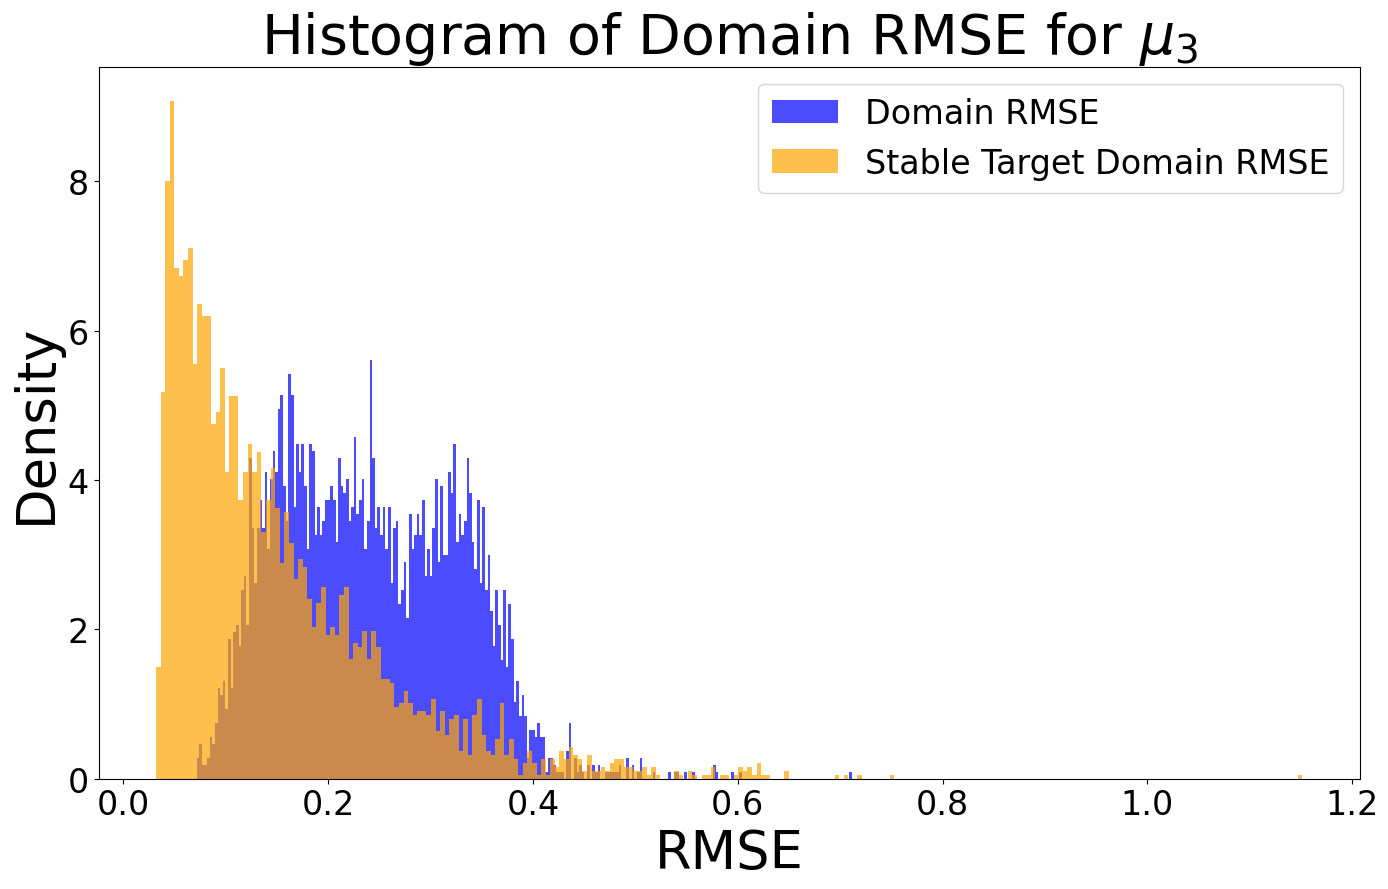

In [85]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
plt.hist(red_domain_rmse, bins=250, alpha=0.7, density=True,color="blue", label="Domain RMSE")
plt.hist(red_sble_tgt_domain_rmse, bins=250, alpha=0.7,density=True, color="orange", label="Stable Target Domain RMSE")
if "BiPot" in config.data_path:
    ax.set_title(r"Histogram of Domain RMSE for $\mu_{3}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        ax.set_title(r"Histogram of Domain RMSE for $\mu_{2}$", fontsize=40)
    else:
        ax.set_title(r"Histogram of Domain RMSE for $\mu_{1}$", fontsize=40)
plt.xlabel("RMSE",fontsize=38)
plt.ylabel("Density",fontsize=38)
ax.tick_params(axis="both",labelsize=24)
plt.legend(fontsize=24)
plt.tight_layout()
if toSave:
    if "BiPot" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_ST_HistLossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_HistLossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    elif "QuadSinHF" in config.data_path:
        if "004b" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_ST_HistLossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                 plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_HistLossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_ST_HistLossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_HistLossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, red_stbl_tgt_losses, s=20, color="orange",label="Stable Target Training Loss")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    ax.set_title(r"Training Losses for $\mu_{3}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        ax.set_title(r"Training Losses for $\mu_{2}$", fontsize=40)
    else:
        ax.set_title(r"Training Losses for $\mu_{1}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=24)
plt.show()
plt.close()

In [ ]:
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)
for losses in [red_losses, red_stbl_tgt_losses]:
    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    fig, ax = plt.subplots(figsize=(14,9))
    sc1 = ax.scatter(common_epochs, short_term_ema, s=10, label="Short Term Loss")
    ax.tick_params(axis="both",labelsize=24)
    ax2 = ax.twinx()
    sc2 = ax2.scatter(common_epochs, long_term_ema, s=20, color="orange",label="Long Term Loss")
    ax.set_xlabel("Training Epochs", fontsize=38)
    if "BiPot" in config.data_path:
        ax.set_title(r"EMA Training Losses for $\mu_{3}$", fontsize=40)
    elif "QuadSinHF" in config.data_path:
        if "004b" in config.data_path:
            ax.set_title(r"EMA Training Losses for $\mu_{2}$", fontsize=40)
        else:
            ax.set_title(r"EMA Training Losses for $\mu_{1}$", fontsize=40)
    ax.tick_params(axis="both",labelsize=24)
    ax2.tick_params(axis="both",labelsize=24)
    plt.tight_layout()
    handles = [sc1, sc2]
    labels = [h.get_label() for h in handles]
    ax.legend(handles, labels, fontsize=24)
    plt.show()
    plt.close()